In [19]:
import sys
sys.path.insert(0, 'utils')
import pandas as pd
import matplotlib.pyplot as plt
import ds_charts as ds
from ds_charts import HEIGHT
import numpy as np
from pandas.plotting import register_matplotlib_converters
import seaborn as sns
import os
register_matplotlib_converters()

%matplotlib inline


darkblue = '#0C70B2'

dataset = 'crime'
suffix = 'crime'
target = 'common_dist'
data_folder = f'data/{dataset}/'
image_dir = f'images/dankfe3_profiling/{dataset}'
savefig = False

if not os.path.exists(image_dir):
        os.makedirs(image_dir)

# data = pd.read_csv(f'{data_folder}{suffix}_base.csv', parse_dates=['current_date'], infer_datetime_format=True)

# data = pd.read_csv(f'{data_folder}{suffix}_dk.csv', parse_dates=['current_date'], infer_datetime_format=True)
# data = pd.read_csv(f'{data_folder}{suffix}_gen_train.csv', parse_dates=['current_date','first_date'], infer_datetime_format=True)
data = pd.read_csv(f'{data_folder}{suffix}_gen_train.csv', parse_dates=['current_date'], infer_datetime_format=True)
# data2 = pd.read_csv(f'{data_folder}{suffix}_gen_test.csv', parse_dates=['current_date','first_date'], infer_datetime_format=True)
data2 = pd.read_csv(f'{data_folder}{suffix}_gen_test.csv', parse_dates=['current_date'], infer_datetime_format=True)

# data = pd.concat([data,data2],axis = 0)

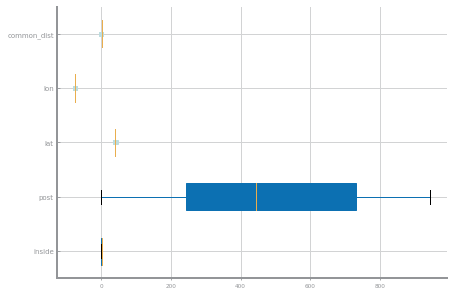

In [3]:
plt.figure(figsize=(7,5))
# data2 = data.drop(columns=['current_date_year'])
data.boxplot(vert=False)
if savefig:
    plt.savefig(f'{image_dir}/global_boxplot.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [ ]:
plt.figure(figsize=(4,2))
values = {'nr records': data.shape[0], 'nr variables': data.shape[1]}
ax = sns.barplot(list(values.keys()), list(values.values()), color = darkblue)
ax.set_title('Nr of records vs nr of variables')
ax.bar_label(ax.containers[0])
if savefig:
    plt.savefig(f'{image_dir}/records_variables.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [ ]:
from numpy import isnan
from datetime import datetime

#Mudanças na funcao: troquei datetime para datetime64[ns] e quando se faz o unique, as datas passam para o formato np.datetime, por isso mudei isso também. 

cat_vars = data.select_dtypes(include='object')
data[cat_vars.columns] = data.select_dtypes(['object']).apply(lambda x: x.astype('category'))

def get_variable_types(df: pd.DataFrame) -> dict:
    variable_types: dict = {
        'numeric': [],
        'binary': [],
        'date': [],
        'symbolic': []
    }
    for c in df.columns:
        uniques = df[c].dropna(inplace=False).unique()
        if len(uniques) == 2:
            variable_types['binary'].append(c)
            df[c].astype('bool')
        elif df[c].dtype == 'datetime64[ns]':
            variable_types['date'].append(c)
        elif df[c].dtype == 'int64':
            variable_types['numeric'].append(c)
        elif df[c].dtype == 'float64':
            variable_types['numeric'].append(c)
        else:
            df[c].astype('category')
            variable_types['symbolic'].append(c)
    return variable_types

variable_types = get_variable_types(data)
counts = {}
print(variable_types)
for tp in variable_types.keys():
    counts[tp] = len(variable_types[tp])
plt.figure(figsize=(4,2))
ax = sns.barplot(list(counts.keys()), list(counts.values()), color = darkblue)
ax.set_title('Nr of variables per type')
ax.bar_label(ax.containers[0])
if savefig:
    plt.savefig(f'{image_dir}/variable_types.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [ ]:
# mv = {}
# for var in data:
#     nr = data[var].isna().sum()
#     if nr > 0:
#         mv[var] = nr
# if len(mv) != 0:
#     plt.figure()
#     ax = sns.barplot(list(mv.keys()), list(mv.values()), color = darkblue)
#     ax.set_title('Nr of missing values per variable')
#     ax.set_xlabel('variables') 
#     ax.set_ylabel('nr missing values')
#     ax.bar_label(ax.containers[0])
#     ax.tick_params(axis='x', rotation=90)
#     if savefig:
#         plt.savefig(f'{image_dir}/mv.png', dpi=300, bbox_inches = 'tight')
#     plt.show()

In [ ]:
# Grafico com os missing values
# ax = sns.heatmap(data.isnull().T, cbar=False)
# ax.invert_yaxis()
# if savefig:
#     plt.savefig(f'{image_dir}/missing_heatmap.png', dpi=300, bbox_inches = 'tight')

In [ ]:
# pd.set_option('display.float_format', lambda x: '%.3f' % x)
# variable_types = get_variable_types(data)
# numeric_vars = variable_types['numeric']
# data[numeric_vars].describe()

In [ ]:
variable_types = get_variable_types(data)
numeric_vars = variable_types['numeric']
rows, cols = ds.choose_grid(len(numeric_vars))
# rows, cols = 5,5
fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
i, j = 0, 0
for n in range(len(numeric_vars)):
    axs[i, j].set_title('Boxplot for %s'%numeric_vars[n])
    axs[i, j].boxplot(data[numeric_vars[n]].dropna().values)
    i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
if savefig:
    plt.savefig(f'{image_dir}/single_boxplots.png', bbox_inches = 'tight', dpi=300)
plt.show()

In [ ]:
NR_STDEV: int = 2

numeric_vars = get_variable_types(data)['numeric']
if [] == numeric_vars:
    raise ValueError('There are no numeric variables.')

outliers_iqr = []
outliers_stdev = []
summary5 = data.describe(include='number')

for var in numeric_vars:
    iqr = 1.5 * (summary5[var]['75%'] - summary5[var]['25%'])
    outliers_iqr += [
        data[data[var] > summary5[var]['75%']  + iqr].count()[var] +
        data[data[var] < summary5[var]['25%']  - iqr].count()[var]]
    std = NR_STDEV * summary5[var]['std']
    outliers_stdev += [
        data[data[var] > summary5[var]['mean'] + std].count()[var] +
        data[data[var] < summary5[var]['mean'] - std].count()[var]]

outliers = {'iqr': outliers_iqr, 'stdev': outliers_stdev}
plt.figure(figsize=(12, HEIGHT))
ds.multiple_bar_chart(numeric_vars, outliers, title='Nr of outliers per variable', xlabel='variables', ylabel='nr outliers', percentage=False)
if savefig:
    plt.savefig(f'{image_dir}/outliers.png', dpi=300, bbox_inches = 'tight')
plt.show()

In [ ]:
# rows,cols = 5,5
# fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
# i, j = 0, 0
# for n in range(len(numeric_vars)):
#     axs[i, j].set_title('Histogram for %s'%numeric_vars[n])
#     axs[i, j].set_xlabel(numeric_vars[n])
#     axs[i, j].set_ylabel("nr records")
#     axs[i, j].hist(data[numeric_vars[n]].dropna().values, 'auto')
#     i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
# if savefig:
#   plt.savefig(f'{image_dir}/single_histograms_numeric.png', bbox_inches = 'tight', dpi=300)
# plt.show()

In [ ]:
# import seaborn as sns
# fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
# i, j = 0, 0
# for n in range(len(numeric_vars)):
#     axs[i, j].set_title('Histogram with trend for %s'%numeric_vars[n])
#     sns.distplot(data[numeric_vars[n]].dropna().values, norm_hist=True, ax=axs[i, j], axlabel=numeric_vars[n])
#     i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
# if savefig:
#   plt.savefig(f'{image_dir}/histograms_trend_numeric.png', bbox_inches = 'tight', dpi=300)
# plt.show()


In [ ]:
# from seaborn import distplot
# import scipy.stats as _stats
# import numpy as np
# import copy
# def compute_known_distributions(x_values: list) -> dict:
#     distributions = dict()
#     # Gaussian
#     mean, sigma = _stats.norm.fit(x_values)
#     distributions['Normal(%.1f,%.2f)'%(mean,sigma)] = _stats.norm.pdf(x_values, mean, sigma)
#     # Exponential
#     loc, scale = _stats.expon.fit(x_values)
#     distributions['Exp(%.2f)'%(1/scale)] = _stats.expon.pdf(x_values, loc, scale)
#     # LogNorm
#     sigma, loc, scale = _stats.lognorm.fit(x_values)
#     distributions['LogNor(%.1f,%.2f)'%(np.log(scale),sigma)] = _stats.lognorm.pdf(x_values, sigma, loc, scale)
#     return distributions

# def histogram_with_distributions(ax: plt.Axes, series: pd.Series, var: str):
#     values = series.sort_values().values
#     ax.hist(values, 20, density=True)
#     # distplot(data[numeric_vars[n]].dropna().values, norm_hist=True, ax=axs[i, j], axlabel=numeric_vars[n], kde=False)
#     distributions = compute_known_distributions(values)
#     ds.multiple_line_chart(values, distributions, ax=ax, title='Best fit for %s'%var, xlabel=var, ylabel='')

# rows, cols = ds.choose_grid(len(numeric_vars))

# fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT))
# i, j = 0, 0
# for n in range(len(numeric_vars)):
#     histogram_with_distributions(axs[i], data[numeric_vars[n]].dropna(), numeric_vars[n])
#     i += 1
# if savefig:
#   plt.savefig(f'{image_dir}/histogram_numeric_distribution.png', bbox_inches = 'tight', dpi=300)
# plt.show()

In [ ]:
symbolic_vars = variable_types['symbolic']
print(symbolic_vars)
if len(symbolic_vars) != 0:
    rows, cols = ds.choose_grid(len(symbolic_vars))
    fig, axs = plt.subplots(rows, cols, figsize=(cols*ds.HEIGHT, rows*ds.HEIGHT), squeeze=False)
    i, j = 0, 0
    for n in range(len(symbolic_vars)):
        counts = data[symbolic_vars[n]].value_counts()
        ax = sns.barplot(counts.index.to_list(), counts.values, ax=axs[i, j], color = '#0C70B2')
        ax.set_title('Histogram for %s'%symbolic_vars[n])
        ax.set_xlabel(symbolic_vars[n])
        ax.set_ylabel('nr records')
        ax.bar_label(ax.containers[0])
        i, j = (i + 1, 0) if (n+1) % cols == 0 else (i, j + 1)
    if savefig:
        plt.savefig(f'{image_dir}/histograms_symbolic.png', bbox_inches = 'tight', dpi=300)
    plt.show()

In [ ]:
plt.figure()
ax = sns.barplot(x=list(data[target].dropna().unique()),y=list(data[target].value_counts()),color = '#0C70B2')
ax.set_title('Class Distribution')
ax.bar_label(ax.containers[0])
if savefig:
    plt.savefig(f'{image_dir}/class_distribution.png', bbox_inches = 'tight', dpi=300)

In [ ]:
# # Data Sparsity
# rows, cols = len(numeric_vars)-1, len(numeric_vars)-1
# plt.figure()
# fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4), squeeze=False)
# for i in range(len(numeric_vars)):
#     var1 = numeric_vars[i]
#     for j in range(i+1, len(numeric_vars)):
#         var2 = numeric_vars[j]
#         axs[i, j-1].set_title("%s x %s"%(var1,var2))
#         axs[i, j-1].set_xlabel(var1)
#         axs[i, j-1].set_ylabel(var2)
#         axs[i, j-1].scatter(data[var1], data[var2], c = data[target])
# if savefig:
#   plt.savefig(f'{image_dir}/sparsity_study_numeric.png', bbox_inches = 'tight', dpi=300)
# plt.show()

In [ ]:
# numeric_vars = get_variable_types(data)['numeric']
# if [] == numeric_vars:
#     raise ValueError('There are no numeric variables.')

# rows, cols = len(numeric_vars)-1, len(numeric_vars)-1
# plt.figure()
# fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4), squeeze=False)
# for i in range(len(numeric_vars)):
#     var1 = numeric_vars[i]
#     var2 = target
#     for j in range(i+1, len(numeric_vars)):
#         axs[i, j-1].set_title("%s x %s"%(var1,var2))
#         axs[i, j-1].set_xlabel(var1)
#         axs[i, j-1].set_ylabel(var2)
#         axs[i, j-1].scatter(data[var1], data[var2], c = data[target])
# if savefig:
#   plt.savefig(f'{image_dir}/sparsity_study_numeric_class.png', bbox_inches = 'tight', dpi=300)
# plt.show()

In [ ]:
# rows, cols = len(symbolic_vars)-1, len(symbolic_vars)-1
# plt.figure()
# fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4), squeeze=False)
# for i in range(len(symbolic_vars)):
#     var1 = symbolic_vars[i]
#     for j in range(i+1, len(symbolic_vars)):
#         var2 = symbolic_vars[j]
#         axs[i, j-1].set_title("%s x %s"%(var1,var2))
#         axs[i, j-1].set_xlabel(var1)
#         axs[i, j-1].set_ylabel(var2)
#         axs[i, j-1].scatter(data[var1], data[var2])
# if savefig:
#   plt.savefig(f'{image_dir}/sparsity_study_symbolic.png', bbox_inches = 'tight', dpi=300)
# plt.show()

In [ ]:
# symbolic_vars = get_variable_types(data)['symbolic']
# if [] == symbolic_vars:
#     raise ValueError('There are no symbolic variables.')

# rows, cols = len(symbolic_vars)-1, len(symbolic_vars)-1
# plt.figure()
# fig, axs = plt.subplots(rows, cols, figsize=(cols*4, rows*4), squeeze=False)
# for i in range(len(symbolic_vars)):
#     var1 = symbolic_vars[i]
#     var2 = target
#     for j in range(i+1, len(symbolic_vars)):
#         axs[i, j-1].set_title("%s x %s"%(var1,var2))
#         axs[i, j-1].set_xlabel(var1)
#         axs[i, j-1].set_ylabel(var2)
#         axs[i, j-1].scatter(data[var1], data[var2], c = data[target])
# if savefig:
#   plt.savefig(f'{image_dir}/sparsity_study_symbolic_class.png', bbox_inches = 'tight', dpi=300)
# plt.show()

In [ ]:
class_values = data[target].value_counts().to_list()
print(data.shape[0])
print(data.shape[1])
print(np.max(class_values) / (np.max(class_values) + np.min(class_values)))

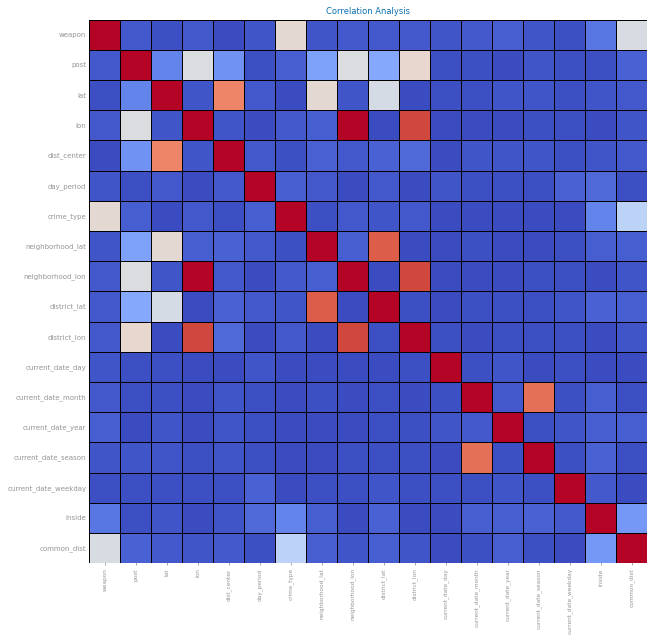

In [20]:
fig = plt.figure(figsize = (10,10))
corr_mtx = data.corr().abs().round(2)
# sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, annot=True, cmap='coolwarm' ,annot_kws={"fontsize":10})
sns.heatmap(corr_mtx, xticklabels=corr_mtx.columns, yticklabels=corr_mtx.columns, cmap='coolwarm' ,linewidths=1,linecolor="black",annot_kws={"fontsize":10}, cbar = False)
plt.title('Correlation Analysis')
savefig = True
if savefig:
    plt.savefig(f'{image_dir}/correlation_analysis.png', bbox_inches = 'tight', dpi=300)
plt.show()